Train with just koopman matrix and then adding sequence model later


In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
import csv


In [3]:
torch.cuda.empty_cache()
exp_dir   = "Trained_Models_Submission/2DCyl/2DCyl_Trained_Model"

models = []

exp_name_list = [
                 "sl33_nhu40_numobs2_bs16_lr5e-5_ph10_TMres_nostateevo",\
                 "Nomem_nhu40_numobs2_bs16_lr5e-5"
                 ]
for exp_name in exp_name_list:
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))



sl33_nhu40_numobs2_bs16_lr5e-5_ph10_TMres_nostateevo
########## Imp Info ##########
System:  2DCyl
Using Non-Linear Autoencoder
Nomem_nhu40_numobs2_bs16_lr5e-5
########## Imp Info ##########
System:  2DCyl
Training without Seqmodel
Using Non-Linear Autoencoder


Plot Learning Curves

Epoch with Minimum train_error:  7956
Epoch with Minimum test_error:  2750


d:\PhD_Projects\Mori-Zwanzig-Autoencoder\src\Eval_MZA.py:458: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig(self.exp_dir+'/'+self.exp_name+"/out_log/StateLoss.png", dpi = 256, facecolor = 'w', bbox_inches='tight')


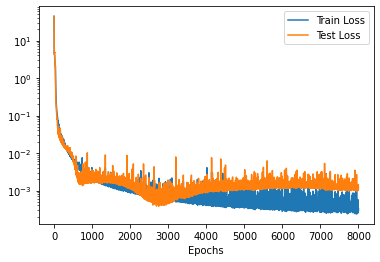

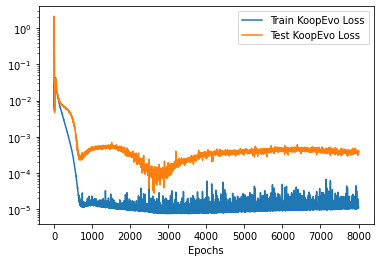

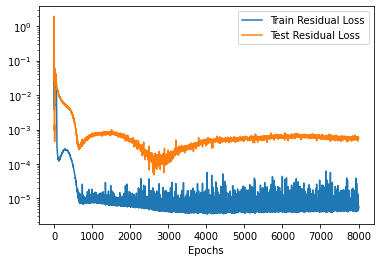

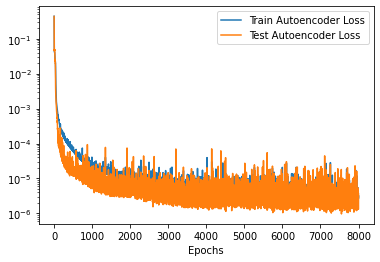

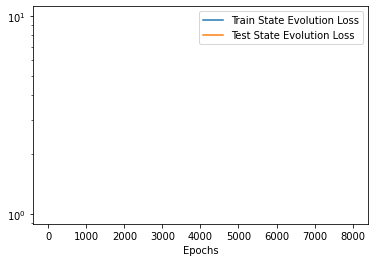

In [4]:
#plot learning curves
models[0].plot_learning_curves()

In [6]:
# Transient Data with numobs5 only
for i in [0,1]:
    #Comment line 4 and 5 if not using the provided trained models
    if  i==0:
        models[i].autoencoder_model = "Autoencoder"
    models[i].autoencoder_model
    models[i].load_weights(min_test_loss = True)

RuntimeError: Error(s) in loading state_dict for MZANetwork:
	Missing key(s) in state_dict: "autoencoder.encoder.0.weight", "autoencoder.encoder.0.bias", "autoencoder.encoder.2.weight", "autoencoder.encoder.2.bias", "autoencoder.encoder.4.weight", "autoencoder.encoder.4.bias", "autoencoder.encoder.6.weight", "autoencoder.encoder.6.bias", "autoencoder.encoder.8.weight", "autoencoder.encoder.8.bias", "autoencoder.decoder.0.weight", "autoencoder.decoder.0.bias", "autoencoder.decoder.2.weight", "autoencoder.decoder.2.bias", "autoencoder.decoder.4.weight", "autoencoder.decoder.4.bias", "autoencoder.decoder.6.weight", "autoencoder.decoder.6.bias", "autoencoder.decoder.8.weight", "autoencoder.decoder.8.bias", "koopman.kMatrix". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict". 

In [6]:
# for i in range(0,len(models)):

ph0 = models[0].pred_horizon 
models[0].pred_horizon = 1


In [7]:
#One Step Prediction
model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Train")
dataset = models[model_num].train_dataset
num_trajs = models[model_num].train_num_trajs

# eval_mza.train_size = 0.9
for i in range(1):#len(models)):
    i=model_num
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape

models[0].pred_horizon = ph0


State Dims:  7938
Not normalizing Input
Train_Shape:  (1, 664, 7938)
Time:  0.11956024169921875
0   torch.Size([32, 7938])


AttributeError: 'Autoencoder' object has no attribute 'relu'

In [8]:
#Load Data
with open('Data/2DCylinder/processed_data/pklfiles/nektar_cyl_data_20_dt0.25_T200.pkl', 'rb') as f:
    data_dict = pickle.load(f)


In [9]:
sub_X = data_dict["sub_X"]
sub_Y = data_dict["sub_Y"]
U_nn = Phi_nn_hat[...,:int(Phi_nn_hat.shape[-1]/2)].detach().cpu().numpy()
V_nn = Phi_nn_hat[...,int(Phi_nn_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_nn.shape, V_nn.shape, U.shape, V.shape


((1, 663, 3969), (1, 663, 3969), (1, 663, 3969), (1, 663, 3969))

In [10]:
def energy(u,v):
    k = 0.5*(np.mean(u**2,axis=-1) + np.mean(v**2,axis=-1))
    return k

k_pred = energy(U_nn,V_nn)
k = energy(U, V)

(1, 663)


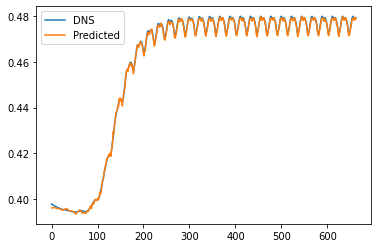

In [11]:
print(k.shape)
plt.plot(k[0,:], label = "DNS")
plt.plot(k_pred[0,:], label = "Predicted")
plt.legend()

In [ ]:
for i in range(100,150):
    plt.figure()
    plt.scatter(sub_X,sub_Y,c=abs((U_nn[0,i]-U[0,i])/U[0,i]), s=1, cmap = 'coolwarm')
    cbar = plt.colorbar()
    # Set the colorbar limits
    cbar.mappable.set_clim(vmin=0, vmax=0.1)
    plt.gca().set_aspect('equal')

    # plt.savefig(models[-3].exp_dir + "/" + models[-3].exp_name + "/error_pred/")

# plt.axes().set_aspect('equal')

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "DNS")
    plt.legend()

plt.ylabel("u0")
plt.xlabel("Timesteps")
plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(koop_out.cpu().numpy()[i,:,1], label = "Koopman Predicted")
    plt.plot(seqmodel_out.cpu().numpy()[i,:,1], label = "Seqmodel Predicted")
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,1], label = "DNS")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

Multi Step prediction

In [13]:
for i in [0,1,2,3,4,5,6,7]:
    models[i].deactivate_seqmodel = True

In [19]:
#multistep prediction
timesteps = 800
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i], xkoop_hat_temp, xseq_hat_temp = models[i].predict_multistep(initial_conditions, timesteps)
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)


ic shape: torch.Size([1, 7938])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([8, 1, 801, 7938]) torch.Size([8, 1, 800, 7938])


In [20]:
U_ms_hat = Phi_ms_hat[...,:int(Phi_ms_hat.shape[-1]/2)].detach().cpu().numpy()
V_ms_hat = Phi_ms_hat[...,int(Phi_ms_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_ms_hat.shape, V_ms_hat.shape, U.shape, V.shape

((8, 1, 801, 3969), (8, 1, 801, 3969), (1, 663, 3969), (1, 663, 3969))

(8, 1, 1001)


Text(0, 0.5, 'Kinetic Energy')

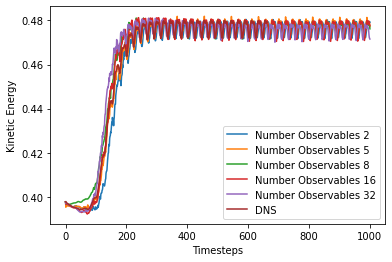

In [89]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
for i in [0,3,4,6,7]:
    plt.plot(k_ms_pred[i,0,:], label = f"Number Observables {models[i].num_obs}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("Kinetic Energy")

In [22]:
U_ms_koop = Phi_ms_koop[...,:int(Phi_ms_koop.shape[-1]/2)].detach().cpu().numpy()
V_ms_koop = Phi_ms_koop[...,int(Phi_ms_koop.shape[-1]/2):].detach().cpu().numpy()

U_ms_koop.shape, V_ms_koop.shape

((8, 1, 800, 3969), (8, 1, 800, 3969))

(8, 1, 800)


Text(0, 0.5, 'kinetic energy')

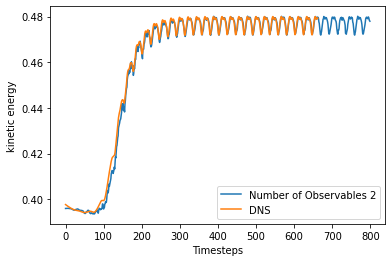

In [23]:
#calculating kinetic energy for multistep prediction
k_ms_koop = energy(U_ms_koop, V_ms_koop)
print(k_ms_koop.shape)
plt.figure()
for i in [0]:
    
    plt.plot(k_ms_koop[i,0,:], label = f"Number of Observables {models[i].num_obs}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

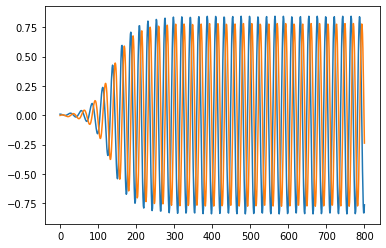

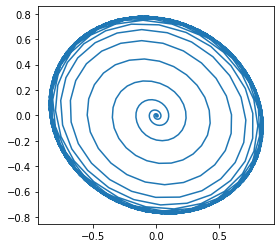

In [24]:
#plotting mode evolution
plt.figure()
model_num = 0
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(x_ms_hat[model_num][0,:,n].cpu().numpy(), label = f"Mode {n}")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(x_ms_hat[model_num][0,:,0].cpu().numpy(), x_ms_hat[model_num][0,:,1].cpu().numpy())

Text(0, 0.5, '$\\mathcal{K}(x_{2})$')

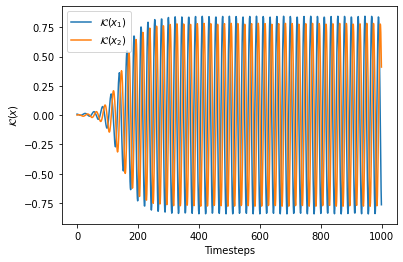

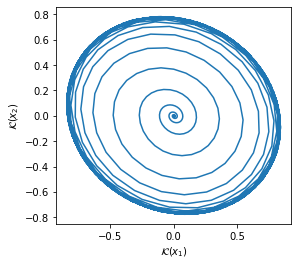

In [45]:
#plotting mode evolution
plt.figure()
model_num = 0
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(xkoop_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\mathcal{K}$"+f"$(x_{n+1})$")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\mathcal{K}(x)$")


plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xkoop_ms_hat[model_num][0,:,0].cpu().numpy(), xkoop_ms_hat[model_num][0,:,1].cpu().numpy())

plt.xlabel(r"$\mathcal{K}(x_{1})$")
plt.ylabel(r"$\mathcal{K}(x_{2})$")

Dictionary has been saved to norm_contribution.csv


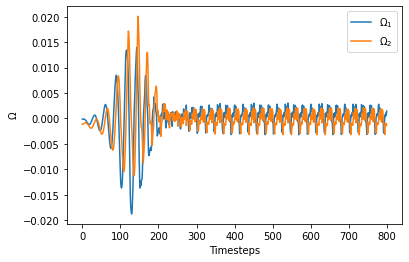

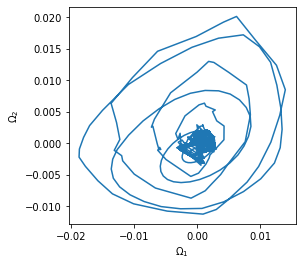

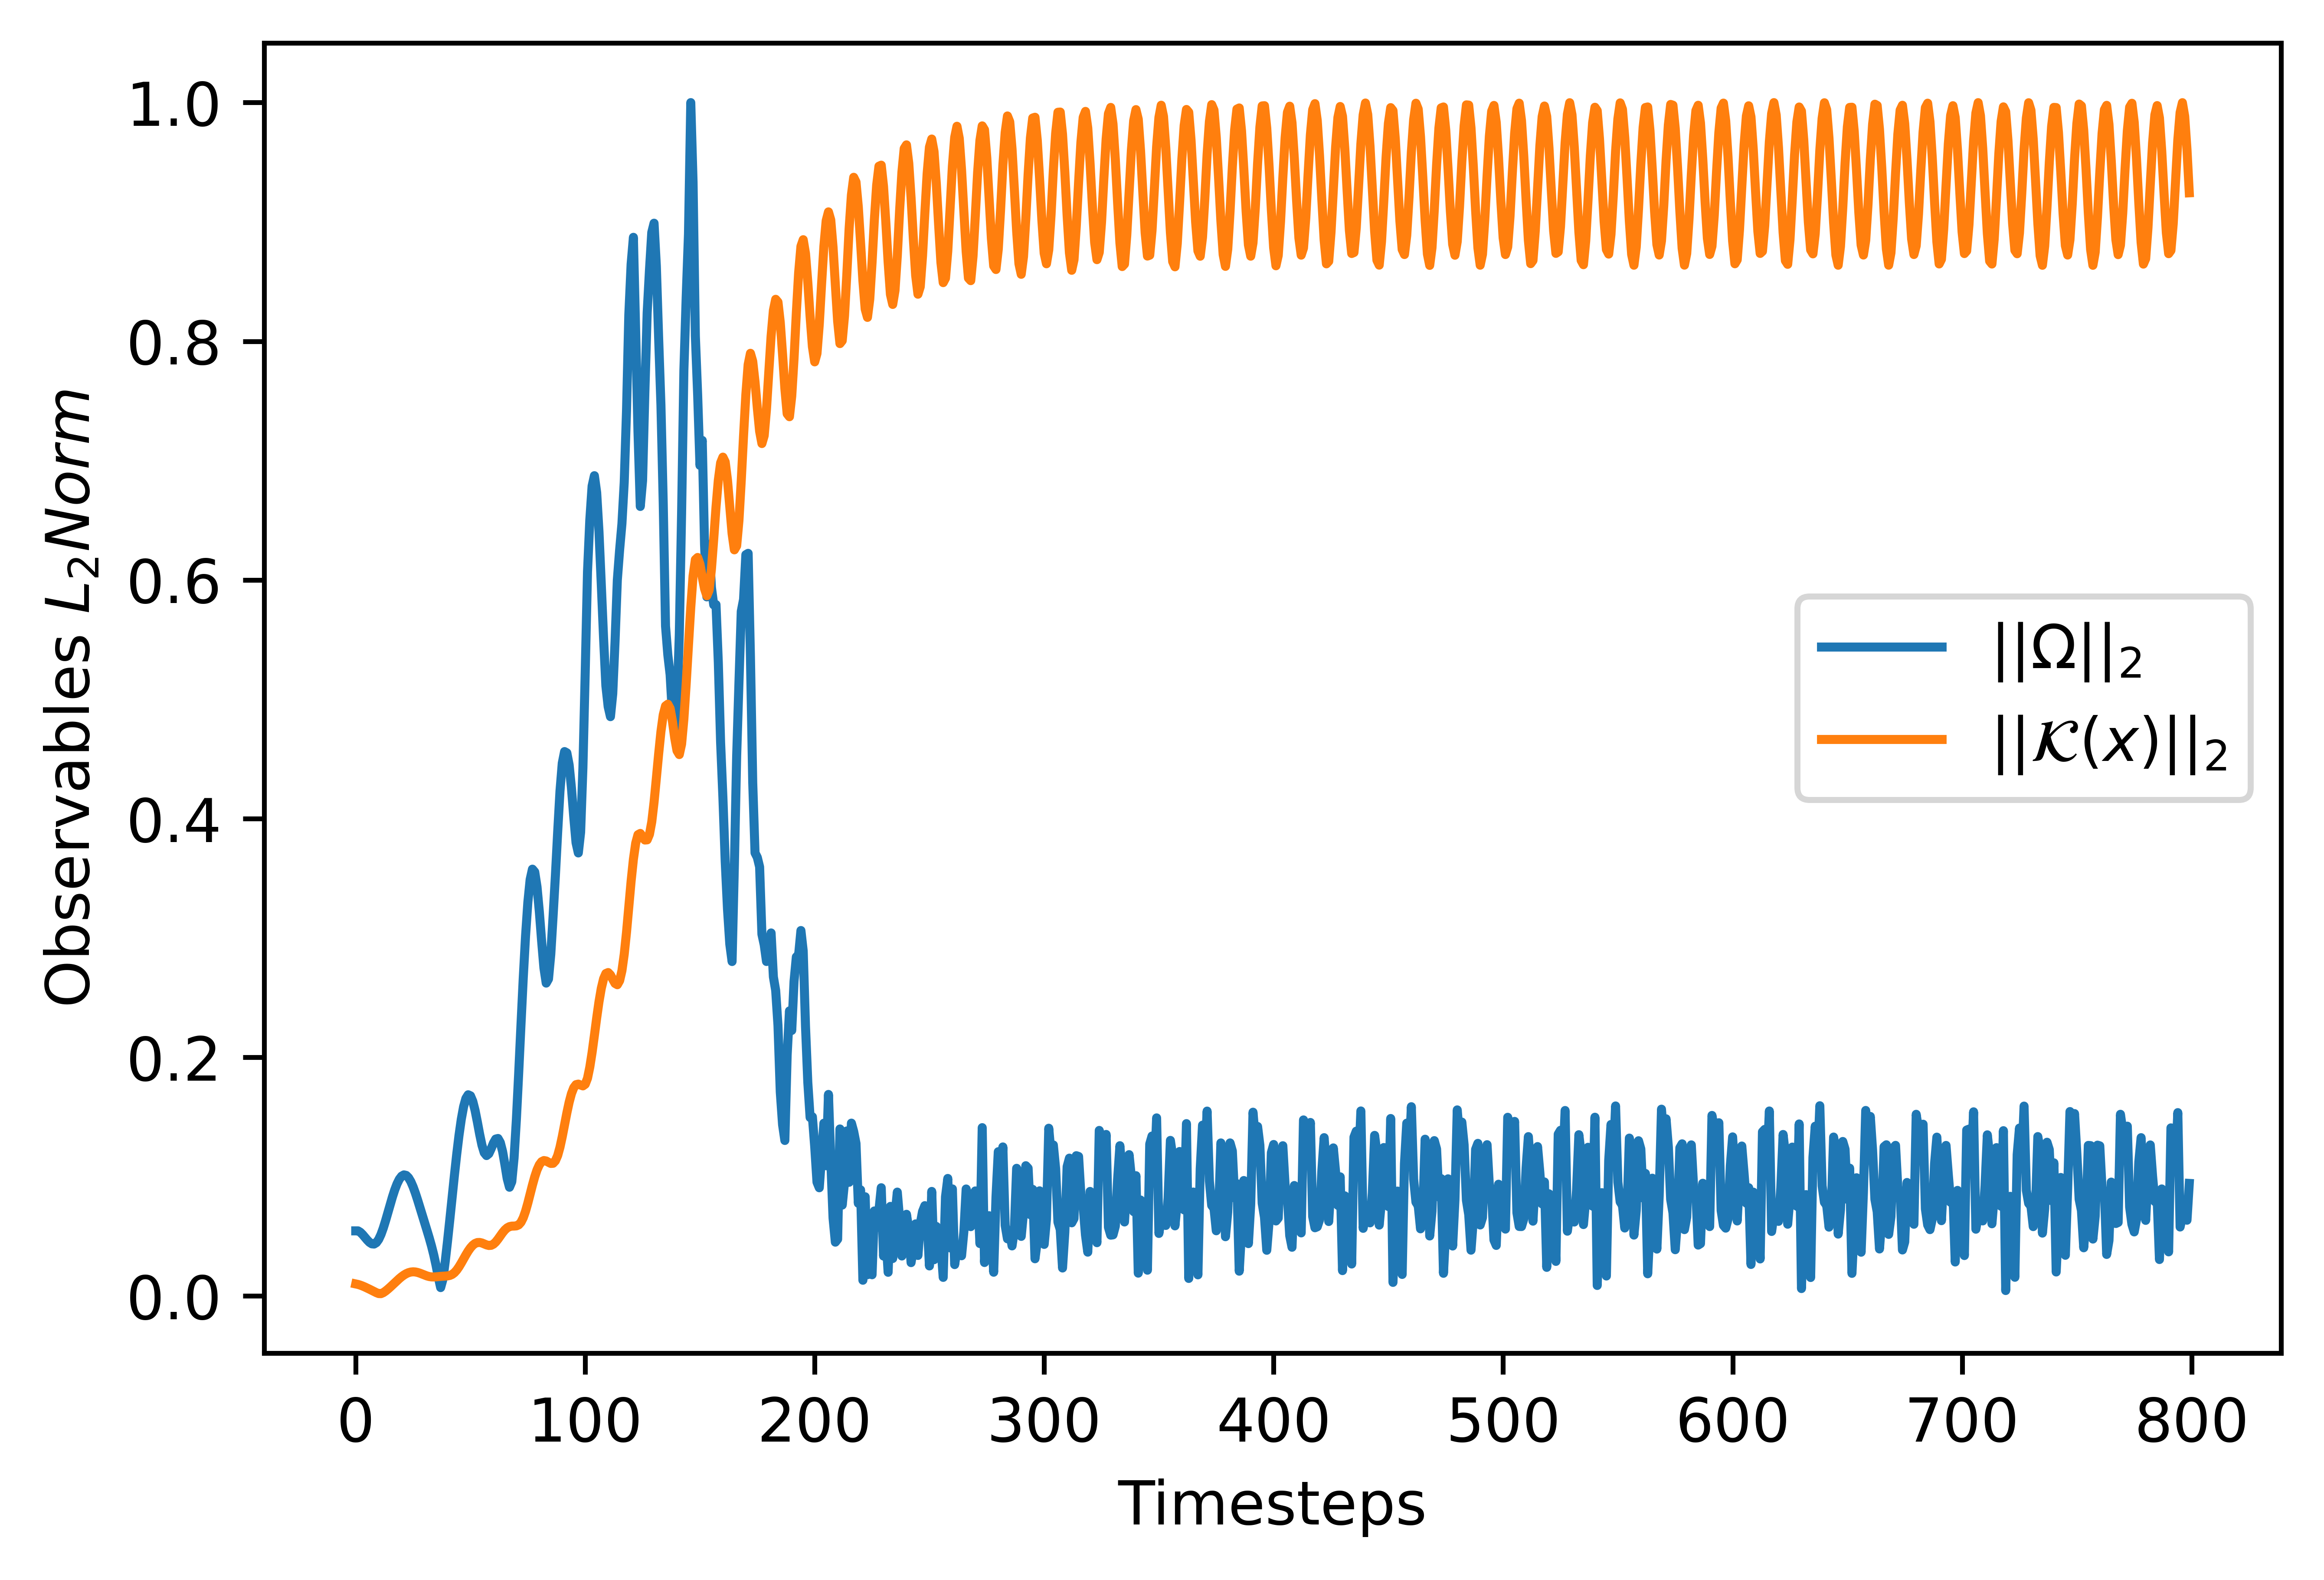

In [25]:
#plotting mode evolution
plt.figure()
model_num = 0
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(xseq_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\Omega$"+f"$_{n+1}$")

plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\Omega$")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xseq_ms_hat[model_num][0,:,0].cpu().numpy(), xseq_ms_hat[model_num][0,:,1].cpu().numpy())
plt.xlabel(f"$\Omega_{1}$")
plt.ylabel(f"$\Omega_{2}$")

plt.figure(dpi = 1000)
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)

plt.plot((tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:], label = r"$||\Omega||_{2}$")
plt.plot((tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:], label = r"$||\mathcal{K}(x)||_{2}$")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("Observables " + r"$  L_{2} Norm$")

csv_file = 'norm_contribution.csv'

data_dict = {"xseq_norm":(tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:],"xkoop_norm":(tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:],"time":np.arange(0,800)}
# Write the dictionary to the CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=data_dict.keys())
    
    # Write the header row
    writer.writeheader()
    
    # Write the data rows
    for row_data in zip(*data_dict.values()):
        writer.writerow(dict(zip(data_dict.keys(), row_data)))

print(f'Dictionary has been saved to {csv_file}')

In [ ]:
#plotting error contours for flowfield
for i in range (300,400,5):
    plt.figure()
    # plt.scatter(sub_X,sub_Y,c=abs((U_ms_hat[-2,0,i]-U[0,i])/U[0,i]), s=1, cmap = 'coolwarm')
    plt.scatter(sub_X,sub_Y,c = U_ms_hat[-1,0,i], s=1, cmap = 'coolwarm')
    cbar = plt.colorbar()
    # Set the colorbar limits
    # cbar.mappable.set_clim(vmin=0, vmax=0.1)
    plt.gca().set_aspect('equal')

    # plt.savefig(models[-1].exp_dir + "/" + models[-1].exp_name + "/out_log/error_plots/fig"+str(i)+".png")

In [86]:
print(Phi_nn.shape, Phi_ms_hat.shape)
State_MSE_multistep = torch.zeros((len(models),timesteps))

plt.figure()
for i in [0,1,2,3,4,5]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    # if i!=len(models)-1:
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Num Obs {models[i].num_obs}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

torch.Size([1, 663, 7938]) torch.Size([8, 1, 2001, 7938])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 2000, 7938])) that is different to the input size (torch.Size([1, 663, 7938])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (663) must match the size of tensor b (2000) at non-singleton dimension 1

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure()
for i in range(len(models)):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Number of Observables {models[i].num_obs}")

plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")

[0.96172726+0.27730274j 0.96172726-0.27730274j]
[ 0.96179897+0.2774135j  0.96179897-0.2774135j -0.53508437+0.j       ]
[ 0.96176183+0.27727595j  0.96176183-0.27727595j -0.05966142+0.j
 -0.50259954+0.j        ]
[ 0.96131575+0.2771911j  0.96131575-0.2771911j  0.6696533 +0.j
 -0.05024539+0.j        -0.5219782 +0.j       ]
[ 0.9991999 +0.j         0.96196586+0.2763715j  0.96196586-0.2763715j
  0.20843051+0.j        -0.32098445+0.8888117j -0.32098445-0.8888117j
 -0.3510359 +0.j        -0.9310802 +0.j       ]
[ 0.9990592 +0.j          0.9619526 +0.27634153j  0.9619526 -0.27634153j
  0.09042566+0.1555951j   0.09042566-0.1555951j  -0.45472804+0.j
 -0.5000922 +0.6045499j  -0.5000922 -0.6045499j  -0.7289381 +0.4081446j
 -0.7289381 -0.4081446j ]
[ 0.99945146+0.j          0.9617707 +0.27637917j  0.9617707 -0.27637917j
  0.5219318 +0.j          0.08165172+0.j          0.05588746+0.40985018j
  0.05588746-0.40985018j  0.04271148+0.8688821j   0.04271148-0.8688821j
 -0.19516279+0.14378014j -0.19516279-

Text(0, 0.5, '$Img(\\lambda)$')

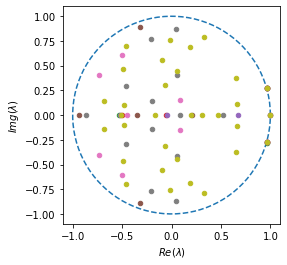

In [94]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', label = "Unit Circle")

for i in [0,1,2,3,4,5,6,7]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), ".", markersize = 9, label = f"Num Observables {models[i].num_obs}")

plt.xlabel(r"$Re(\lambda)$")
plt.ylabel(r"$Img(\lambda)$")
# plt.legend()

array([0.00057757+0.17871438j, 0.00057757-0.17871438j], dtype=complex64)

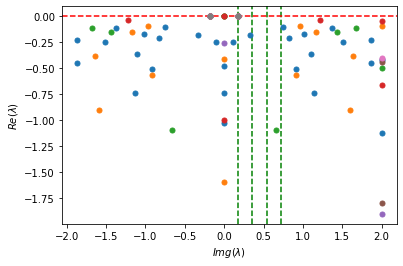

In [6]:
plt.figure()
plt.axvline(0.18, color='green', linestyle='--')
plt.axvline(0.36, color='green', linestyle='--')
plt.axvline(3*0.18, color='green', linestyle='--')
plt.axvline(4*0.18, color='green', linestyle='--')
plt.axhline(0, color='red', linestyle='--')

# plt.text(0.17, 0.075, 'x = 0.17', color='green')
for i in [7,6,5,4,3,2,1,0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.25)/(2*np.pi)
    plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", markersize = 10, label = f"Num Observables {models[i].num_obs}")

plt.ylabel(r"$Re(\lambda)$")
plt.xlabel(r"$Img(\lambda)$")

# plt.ylim(-0.1,0.1)
# plt.xlim(-1,1)
# plt.legend()
lamb

<Figure size 432x288 with 0 Axes>

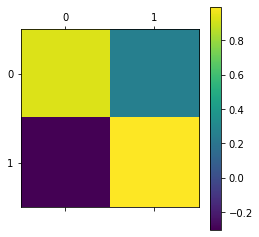

In [56]:
#Matrix
plt.figure()


for i in [0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    plt.matshow(mat)
    plt.colorbar()
    # plt.figure()
    # plt.plot(np.real(w), np.imag(w), ".", label = f"Num Observables {models[i].num_obs}")

# plt.legend()

In [ ]:
error = np.zeros((1,models[-1].num_obs))
for i in range(error.shape[1]):
    error[0,i] = np.linalg.norm(mat*v[:,i] - w[i]*mat,ord="fro")
print(error)

In [ ]:
#decoding the eigenvectors
print(v.shape)
tv = torch.tensor(np.real(v)).to(models[-2].device)

koopmodes = models[-2].model.autoencoder.recover(tv)
koopmodes.shape

In [ ]:
plt.figure()
plt.scatter(sub_X,sub_Y,c=koopmodes.detach().cpu().numpy()[0,:], s=1, cmap = 'coolwarm')

RESDMD

In [15]:
import copy
# plt.figure(dpi = 1000)

# plt.axhline(0, color='red', linestyle='--')
# plt.axvline(x=0, color='black', linestyle='--')


# plt.text(0.17, 0.075, 'x = 0.17', color='green')
for i in [0,1,2,3,4,5,6,7]:
    print("model number: ", i)
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    # print(w.shape)

    lamb = (np.log(w)/0.25)

    term1 = np.matmul(mat,v)
    term2 = np.matmul(v,np.diag(w))

    res = np.linalg.norm(term1 - term2,axis=-1)

    print(res)

#     if i == 2:
#         plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", color = "darkviolet", markersize = 10, label = "MZ-AE")
#         lamb_mzae = copy.deepcopy(lamb)
#     else:
#         plt.plot(np.imag(lamb[:]),np.real(lamb[:]),"x", color = "blue", markersize = 7, label = "Without Memory")
#         lamb_wm = copy.deepcopy(lamb)
# plt.ylabel(r"$Re(\mu)$")
# plt.xlabel(r"$Img(\mu)$")
# plt.grid("on")
# plt.ylim(-0.15,0.1)
# # plt.xlim(-1,1)
# plt.legend(loc = "upper center")
# # lamb

model number:  0
[0. 0.]
model number:  1
[4.4703484e-08 3.1610135e-08 1.4901161e-08]
model number:  2
[4.3483890e-08 1.1175871e-08 3.1828893e-08 2.5936330e-08]
model number:  3
[6.4200492e-08 2.1400163e-08 1.0030651e-08 2.0425500e-08 1.1349151e-08]
model number:  4
[6.4308480e-08 9.0102752e-08 6.7390694e-08 1.1152564e-07 9.1823871e-08
 2.5338991e-08 8.4293696e-08 7.5016281e-08]
model number:  5
[4.9771327e-08 8.1617024e-08 9.6785882e-08 9.5921706e-08 3.0556748e-08
 5.9894973e-08 7.6572611e-08 5.5340429e-08 3.6237903e-08 8.8038313e-08]
model number:  6
[6.7160244e-08 6.1354299e-08 6.9944008e-08 5.7561934e-08 6.7139666e-08
 8.4237492e-08 1.0023731e-07 7.6866563e-08 4.5606289e-08 6.1778707e-08
 5.1031890e-08 7.8433786e-08 9.2495767e-08 7.8257422e-08 5.6371000e-08
 5.8280257e-08]
model number:  7
[1.09724269e-07 1.02681611e-07 8.34029876e-08 8.60062670e-08
 8.48797868e-08 8.65528946e-08 6.76942804e-08 7.01180340e-08
 7.51087228e-08 8.03473199e-08 8.97105465e-08 7.19657720e-08
 7.09549255e